# Model 1 — Baseline Risk Classifier (Logistic Regression)

This notebook builds an interpretable baseline model to predict whether a wine is **high risk of low technical quality** based only on physicochemical properties.

The objective is not to maximize overall accuracy, but to:
- Establish a reliable **baseline** for risk detection
- Prioritize **recall for the high-risk class** (minimize false negatives)
- Provide a transparent reference model to support later threshold tuning and risk calibration



## 1. Problem Framing

This is a supervised **binary classification** problem.  
The objective is to predict whether a wine presents a **high risk of low technical quality**, based exclusively on its chemical composition.

- **Target variable:**  
  `risk = 1` if `quality ≤ 5`, else `risk = 0`

- **Model type:**  
  Classification (Logistic Regression baseline)

- **Primary focus:**  
  Interpretability and recall for the high-risk class, rather than overall accuracy



In [1]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [2]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
WINE_QUALITY_FILE = config["files"]["wine_quality"]


## 2. Data loading

The Wine Quality dataset is loaded as the source of analytical quality measurements derived from chemical composition.


In [3]:
wine_quality = pd.read_csv(RAW_PATH / WINE_QUALITY_FILE)
wine_quality.head()



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


## 3. Feature and target definition

All physicochemical variables are used as features.
The quality score is used as the prediction target.


In [4]:
X = wine_quality.drop(columns=["quality", "Id"], errors="ignore")
y = wine_quality["quality"]

X.shape, y.shape


((1143, 11), (1143,))

In [49]:
# Create risk target (must exist before splitting)
wine_quality["risk"] = (wine_quality["quality"] <= 5).astype(int)

# Quick check
print(wine_quality["risk"].value_counts())
print(wine_quality["risk"].value_counts(normalize=True))


risk
0    621
1    522
Name: count, dtype: int64
risk
0    0.543307
1    0.456693
Name: proportion, dtype: float64


In [50]:
from sklearn.model_selection import train_test_split

X = wine_quality.drop(columns=["quality", "risk", "Id", "alcohol_segment_3"])
y = wine_quality["risk"]

## 4. Train-test split

The dataset is split into training and testing sets to evaluate generalization performance.


In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train distribution:\n", y_train.value_counts())
print("\nTest distribution:\n", y_test.value_counts())


Train distribution:
 risk
0    497
1    417
Name: count, dtype: int64

Test distribution:
 risk
0    124
1    105
Name: count, dtype: int64


## 5. Baseline Risk Model

This section trains an interpretable baseline classifier to predict **low-quality risk** based exclusively on physicochemical features.

The model serves as a reference point to:
- Establish a minimum viable performance for risk detection
- Evaluate recall for the high-risk class under correct train–test separation
- Provide a transparent benchmark for later modeling improvements



In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        random_state=42,
        max_iter=1000
    ))
])


### Model Training

The baseline model is trained using only the training set to avoid data leakage.


In [53]:
baseline_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## 6. Baseline Evaluation (Test Set)

The baseline model is evaluated on the held-out test set to estimate generalization performance.
Given the business objective (minimize false negatives), the primary focus is **recall for the high-risk class** (`risk = 1`).
Supporting metrics include ROC-AUC and PR-AUC.


In [55]:

# Predict class labels and probabilities on the test set
y_pred = baseline_pipeline.predict(X_test)
y_proba = baseline_pipeline.predict_proba(X_test)[:, 1]


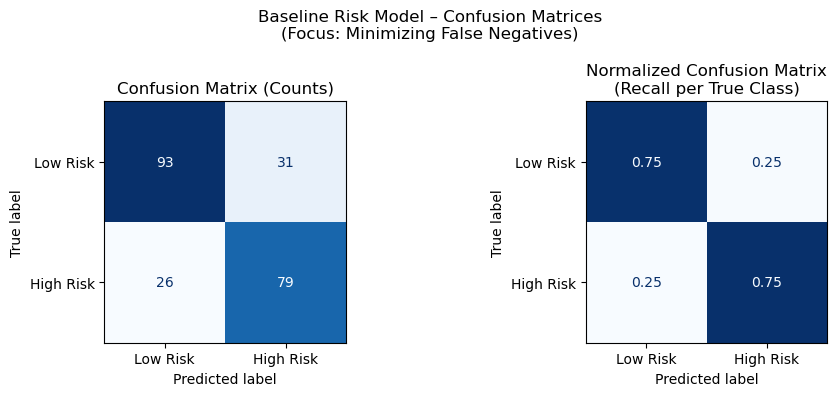

Saved figure to: C:\Users\Marta\ironhack\final_project\wine-analysis-project\notebooks\reports\figures\confusion_matrices_baseline.png


In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalized confusion matrix (row-wise: recall per class)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# --- Define output path (recommended repo structure) ---
out_dir = Path("reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "confusion_matrices_baseline.png"

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Absolute counts ---
disp_counts = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Low Risk", "High Risk"]
)
disp_counts.plot(
    ax=axes[0],
    cmap="Blues",
    values_format="d",
    colorbar=False
)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")

# --- Normalized (recall per class) ---
disp_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=["Low Risk", "High Risk"]
)
disp_norm.plot(
    ax=axes[1],
    cmap="Blues",
    values_format=".2f",
    colorbar=False
)
axes[1].set_title("Normalized Confusion Matrix\n(Recall per True Class)")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")

# Global title
fig.suptitle(
    "Baseline Risk Model – Confusion Matrices\n(Focus: Minimizing False Negatives)",
    fontsize=12
)

plt.tight_layout()
plt.show()

# --- Save before show ---
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved figure to: {out_path.resolve()}")

The left matrix shows the absolute number of correct and incorrect classifications, while the normalized matrix highlights recall per true class. In particular, the model correctly identifies approximately 75% of high-risk wines, while the remaining false negatives represent the most critical errors to address in subsequent modeling stages.

In [57]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Low Risk (0)", "High Risk (1)"]
    )
)



               precision    recall  f1-score   support

 Low Risk (0)       0.78      0.75      0.77       124
High Risk (1)       0.72      0.75      0.73       105

     accuracy                           0.75       229
    macro avg       0.75      0.75      0.75       229
 weighted avg       0.75      0.75      0.75       229



In [58]:
from sklearn.metrics import roc_auc_score, average_precision_score

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC:  {pr_auc:.3f}")



ROC-AUC: 0.823
PR-AUC:  0.785


### Key metric (High Risk Recall)

Recall for the high-risk class measures how many truly risky wines are correctly flagged.
This metric is prioritized because false negatives are more costly than false positives in a preventive risk setting.


In [59]:
from sklearn.metrics import recall_score, precision_score

risk_recall = recall_score(y_test, y_pred, pos_label=1)
risk_precision = precision_score(y_test, y_pred, pos_label=1)

print(f"High Risk Recall (class 1):    {risk_recall:.3f}")
print(f"High Risk Precision (class 1): {risk_precision:.3f}")


High Risk Recall (class 1):    0.752
High Risk Precision (class 1): 0.718


With no threshold tuning, no calibration, and a simple interpretable model, the baseline already achieves strong risk recall.

## 7. Baseline Model Interpretation

To maintain interpretability, the coefficients of the logistic regression model are examined.
Coefficients are transformed into odds ratios to quantify how changes in chemical variables
affect the odds of a wine being classified as high risk.


In [60]:
import pandas as pd
import numpy as np

# Extract model coefficients
model = baseline_pipeline.named_steps["model"]
feature_names = X_train.columns

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": model.coef_[0],
})

coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
coef_df = coef_df.sort_values("odds_ratio", ascending=False)

coef_df


,feature,coefficient,odds_ratio
1,volatile acidity,0.591329,1.806387
6,total sulfur dioxide,0.546459,1.727126
2,citric acid,0.340473,1.405613
4,chlorides,0.182274,1.199943
8,pH,0.094820,1.099461
3,residual sugar,-0.007628,0.992401
7,density,-0.073668,0.928980
0,fixed acidity,-0.202148,0.816974
5,free sulfur dioxide,-0.213447,0.807795
9,sulphates,-0.529418,0.588947


### Interpretation Summary

- Variables with odds ratios above 1 increase the likelihood of low-quality risk.
- Variables with odds ratios below 1 act as protective factors.
- Volatile acidity and total sulfur dioxide emerge as key risk amplifiers,
  while alcohol and sulphates show strong protective effects.

These results are consistent with both the exploratory analysis and the
risk-focused business framing of the project.
